# [Practical Text Classification With Python and Keras - CNN](https://realpython.com/python-keras-text-classification/?fbclid=IwAR0uuIjJZMfOsT0BDBT_-MQnW3MjwZqpFZ3xkEh2TwZLjbgki5zfeiP91KM)

Imagine you could know the mood of the people on the Internet. Maybe you are not interested in its entirety, but only if people are today happy on your favorite social media platform. After this tutorial, you’ll be equipped to do this. While doing this, you will get a grasp of current advancements of (deep) neural networks and how they can be applied to text.

Reading the mood from text with machine learning is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) , and it is one of the prominent use cases in text classification. This falls into the very active research field of natural language processing (NLP). Other common use cases of text classification include detection of spam, auto tagging of customer queries, and categorization of text into defined topics. So how can you do this?

### Reference:

https://realpython.com/python-keras-text-classification

### Dataset
https://archive.ics.uci.edu/ml/machine-learning-databases/00331/

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

## Dataset
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015
Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment, extracted from reviews of products, movies, and restaurants


### Format:
sentence \t score \n


### Details:

Score is either 1 (for positive) or 0 (for negative)	
The sentences come from three different websites/fields:

```
imdb.com
amazon.com
yelp.com
```

For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews. 

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- imdb: Maas et. al., 2011 'Learning word vectors for sentiment analysis'
- amazon: McAuley et. al., 2013 'Hidden factors and hidden topics: Understanding rating dimensions with review text'
- yelp: Yelp dataset challenge http://www.yelp.com/dataset_challenge



In [2]:
from google.colab import files

uploaded = files.upload()

Saving sentiment_label_sentences.tar to sentiment_label_sentences.tar


In [3]:
! tar -xvf sentiment_label_sentences.tar
! rm -rf sentiment_label_sentences.tar

sentiment_label_sentences/imdb_labelled.txt
sentiment_label_sentences/yelp_labelled.txt
sentiment_label_sentences/
sentiment_label_sentences/amazon_cells_labelled.txt


In [4]:
! ls sentiment_label_sentences

amazon_cells_labelled.txt  imdb_labelled.txt  yelp_labelled.txt


In [8]:
filepath_dict = {
    'yelp':   'sentiment_label_sentences/yelp_labelled.txt',
    'amazon': 'sentiment_label_sentences/amazon_cells_labelled.txt',
    'imdb':   'sentiment_label_sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

display(df.info())
display(df.head())

display(print('Label value count:'))
display(df['label'].value_counts())

display(print('Source value count:'))
display(df['source'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
sentence    2748 non-null object
label       2748 non-null int64
source      2748 non-null object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


None

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


Label value count:


None

1    1386
0    1362
Name: label, dtype: int64

Source value count:


None

amazon    1000
yelp      1000
imdb       748
Name: source, dtype: int64

## Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Train data from all dataset
X = df['sentence'].values
y = df['label'].values


# Train/test split
X_sentence_train, X_sentence_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1000)

display(X_sentence_train.shape)
display(y_train.shape)
display(X_sentence_test.shape)
display(y_test.shape)

print('')
display(X_sentence_train[0])
display(y_train[0])

print('')
display(X_sentence_train[5])
display(y_train[5])

(2061,)

(2061,)

(687,)

(687,)

"I'd rather eat airline food, seriously."

0

'Highly recommended A+  '

1

## Feature Engineering - Word Embeddings

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Torkenize the sentences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_sentence_train) 
    ### Since you might not have the testing data available during training,
    ### you can create the vocabulary using only the training data

# Tokenization 
X_train = tokenizer.texts_to_sequences(X_sentence_train)
X_test = tokenizer.texts_to_sequences(X_sentence_test)

# vocab size
vocab_size = len(tokenizer.word_index) + 1

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

display(X_train_pad.shape)
display(X_test_pad.shape)

(2061, 100)

(687, 100)

## Model - CNN
- Working with sequential data, like text
        -> work with one dimensional convolutions
    
-  one dimensional convnet is invariant to translations
        -> Certain sequences can be recognized at a different position 
        -> Discover certain patterns in the text
        
<img src="images/njanakiev-1d-convolution.jpg" alt="drawing" width="600"/>

- CNN not work well on this dataset
    - There are not enough training samples
    - The data does not generalize well

- CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

In [11]:
from keras.models import Sequential
from keras import layers
import keras.backend as K

embedding_dim = 100

K.clear_session()
model = Sequential()

model.add(layers.Embedding(
    vocab_size, 
    embedding_dim, 
    input_length=maxlen))

# CNN
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          460300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 525,729
Trainable params: 525,729
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0, mode='auto')

history = model.fit(
    X_train_pad, y_train,
    epochs=50,
    verbose=False,
    validation_split=0.3,
    callbacks=[early_stopping],
    batch_size=10)

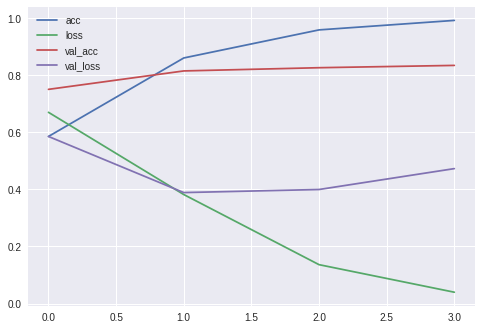

In [13]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

In [14]:
loss, accuracy = model.evaluate(
    X_train_pad, y_train,
    verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9495


## Evaluate

In [15]:
loss, accuracy = model.evaluate(
    X_test_pad, y_test, 
    verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Testing Accuracy: 0.8195


## Grid Search

In [0]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    K.clear_session()
    model = Sequential()

    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):

    print('Running grid search for data set :', source)

    # X, y
    X = df['sentence'].values
    y = df['label'].values

    # Train-test split
    X_sentence_train, X_sentence_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=1000)

    # Torkenize the sentences
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_sentence_train)

    # Tokenization 
    X_train = tokenizer.texts_to_sequences(X_sentence_train)
    X_test = tokenizer.texts_to_sequences(X_sentence_test)

    # vocab size
    vocab_size = len(tokenizer.word_index) + 1

    # Padding
    maxlen = 100
    X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Model
    model = KerasClassifier(
        build_fn=create_model,
        epochs=epochs, batch_size=10,
        verbose=False)

    # Parameter grid for grid search
    param_grid = dict(
        num_filters=[32, 64, 128],
        kernel_size=[3, 5, 7],
        vocab_size=[vocab_size],
        embedding_dim=[embedding_dim],
        maxlen=[maxlen])
    
    # Grid search
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train_pad, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test_pad, y_test)

    # Evaluate and print results
    print('''
        Running {} data set
            Best Accuracy : {:.4f}
            Best params: {}
            Test Accuracy : {:.4f}\n\n
        '''.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy))

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.4min finished



        Running amazon data set
            Best Accuracy : 0.8127
            Best params: {'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
            Test Accuracy : 0.8166


        
Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.4min finished



        Running imdb data set
            Best Accuracy : 0.8185
            Best params: {'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
            Test Accuracy : 0.8399


        
Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 11.7min finished



        Running yelp data set
            Best Accuracy : 0.8142
            Best params: {'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
            Test Accuracy : 0.8282


        


In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

# X, y
X = df['sentence'].values
y = df['label'].values

# Train-test split
X_sentence_train, X_sentence_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1000)

# Torkenize the sentences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_sentence_train)

# Tokenization 
X_train = tokenizer.texts_to_sequences(X_sentence_train)
X_test = tokenizer.texts_to_sequences(X_sentence_test)

# vocab size
vocab_size = len(tokenizer.word_index) + 1

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Model
model = KerasClassifier(
    build_fn=create_model,
    epochs=epochs, 
    batch_size=10,
    validation_split=0.3,
    verbose=False)

# Parameter grid for grid search
param_grid = dict(
    num_filters=[32, 64, 128],
    kernel_size=[3, 5, 7],
    vocab_size=[vocab_size],
    embedding_dim=[embedding_dim],
    maxlen=[maxlen])

# Grid search
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=4, verbose=1, n_iter=5)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0, mode='auto')

grid_result = grid.fit(
    X_train_pad, y_train,
    callbacks=[early_stopping])

# Evaluate testing set
test_accuracy = grid.score(X_test_pad, y_test)

# Evaluate and print results
print('''
        Best Accuracy : {:.4f}
        Best params: {}
        Test Accuracy : {:.4f}\n\n
    '''.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy))

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.0min finished



    Running yelp data set
        Best Accuracy : 0.7962
        Best params: {'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
        Test Accuracy : 0.8035


    
